In [ ]:
!pip install numpy matplotlib svgwrite cairosvg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, splprep, splev
import os

#Upload CSV Files

In [ ]:
from google.colab import files

# Upload the ZIP file containing your CSV data
uploaded = files.upload()


Saving problems.zip to problems.zip


In [ ]:
import zipfile
import os

# Ensure the correct filename is used
zip_file_name = 'problems.zip'  # Make sure this matches your uploaded ZIP filename

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('curvetopia_data')

# List the extracted files to confirm the correct files are present
extracted_files = os.listdir('curvetopia_data')
print("Extracted files:", extracted_files)


Extracted files: ['problems', '__MACOSX']


In [ ]:
# List files inside the 'problems' directory
problems_path = 'curvetopia_data/problems'
extracted_files = os.listdir(problems_path)
print("Files in 'problems':", extracted_files)


Files in 'problems': ['frag1.svg', 'isolated_sol.svg', 'occlusion2_rec.png', 'isolated_sol.csv', 'frag0.svg', 'occlusion1_rec.png', '.DS_Store', 'occlusion1_rec.svg', 'occlusion2_sol_rec.svg', 'occlusion2_sol.csv', 'frag2.svg', 'isolated.svg', 'occlusion1_sol.svg', 'frag1.csv', 'isolated.csv', 'occlusion2_sol_rec.png', 'occlusion1_sol_rec.png', 'frag2_sol.svg', 'occlusion2_rec.svg', 'frag2.csv', 'frag01_sol.csv', 'occlusion2.svg', 'frag0.csv', 'occlusion2.csv', 'occlusion1_sol.csv', 'occlusion1.csv', 'occlusion1.svg', 'frag2_sol.csv', 'occlusion1_sol_rec.svg', 'occlusion2_sol.svg', 'frag01_sol.svg']


#Load and Visualize Data


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

def plot(path_XYs, title="Plot"):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['r', 'g', 'b', 'y', 'm', 'c']

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    ax.set_title(title)  # Set the title of the plot
    plt.show()



#4. Curve Regularization
#Implement basic detection and regularization for shapes like lines and circles:

In [ ]:
def detect_straight_lines(path_XYs, threshold=1e-3):
    lines = []
    for XYs in path_XYs:
        for XY in XYs:
            x = XY[:, 0]
            y = XY[:, 1]
            # Linear regression to check straight lines
            A = np.vstack([x, np.ones(len(x))]).T
            m, c = np.linalg.lstsq(A, y, rcond=None)[0]
            # Fit error
            fit_error = np.sum((y - (m * x + c)) ** 2)
            if fit_error < threshold:  # Check against threshold
                lines.append(XY)
    return lines

def detect_circles(path_XYs, threshold=1e-1):
    circles = []
    for XYs in path_XYs:
        for XY in XYs:
            # Calculate center and radius using least squares
            x = XY[:, 0]
            y = XY[:, 1]
            x_m = np.mean(x)
            y_m = np.mean(y)
            u = x - x_m
            v = y - y_m
            Suv = np.sum(u*v)
            Suu = np.sum(u**2)
            Svv = np.sum(v**2)
            Suuv = np.sum(u**2*v)
            Suvv = np.sum(u*v**2)
            Suuu = np.sum(u**3)
            Svvv = np.sum(v**3)

            # Solving for circle center
            A = np.array([[Suu, Suv], [Suv, Svv]])
            B = np.array([Suuu + Suvv, Svvv + Suuv]) / 2.0
            uc, vc = np.linalg.solve(A, B)
            xc_1 = x_m + uc
            yc_1 = y_m + vc
            R_1  = np.mean(np.sqrt((x-xc_1)**2 + (y-yc_1)**2))
            residu_1 = np.sum((np.sqrt((x-xc_1)**2 + (y-yc_1)**2) - R_1)**2)
            if residu_1 < threshold:
                circles.append(XY)
    return circles


#5. Symmetry Detection
# Detect symmetrical shapes by comparing mirrored halves

In [ ]:
def check_reflection_symmetry(XY, threshold=1e-2):
    mid_index = len(XY) // 2
    left = XY[:mid_index]
    right = XY[mid_index:][::-1]  # Reverse for comparison
    return np.allclose(left, right, atol=threshold)


#6. Curve Completion
#Fill gaps in curves using interpolation:

In [ ]:
def complete_curve(XY, num_points=100):
    x = XY[:, 0]
    y = XY[:, 1]
    interp_func = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    new_x = np.linspace(x.min(), x.max(), num=num_points)
    new_y = interp_func(new_x)
    return np.column_stack((new_x, new_y))


#7. Bézier Curve Fitting
#Fit cubic Bézier curves to the data for smoother representation:

In [ ]:
def fit_bezier(XY, num_points=100):
    tck, u = splprep([XY[:, 0], XY[:, 1]], s=0)
    new_points = splev(np.linspace(0, 1, num_points), tck)
    return np.array(new_points).T


#8. Execution
#Now, you can run the entire process using your CSV files:

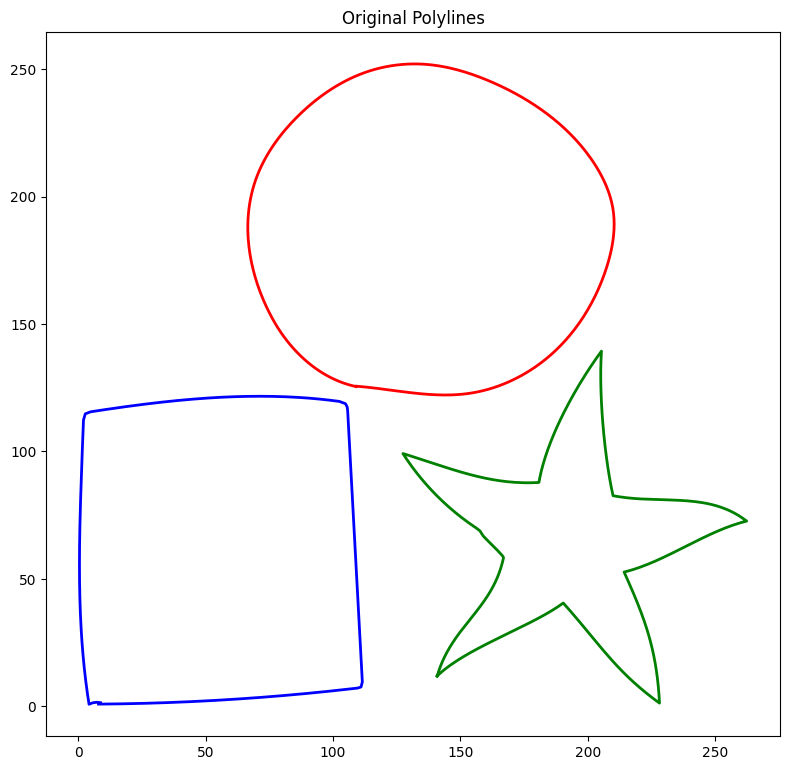

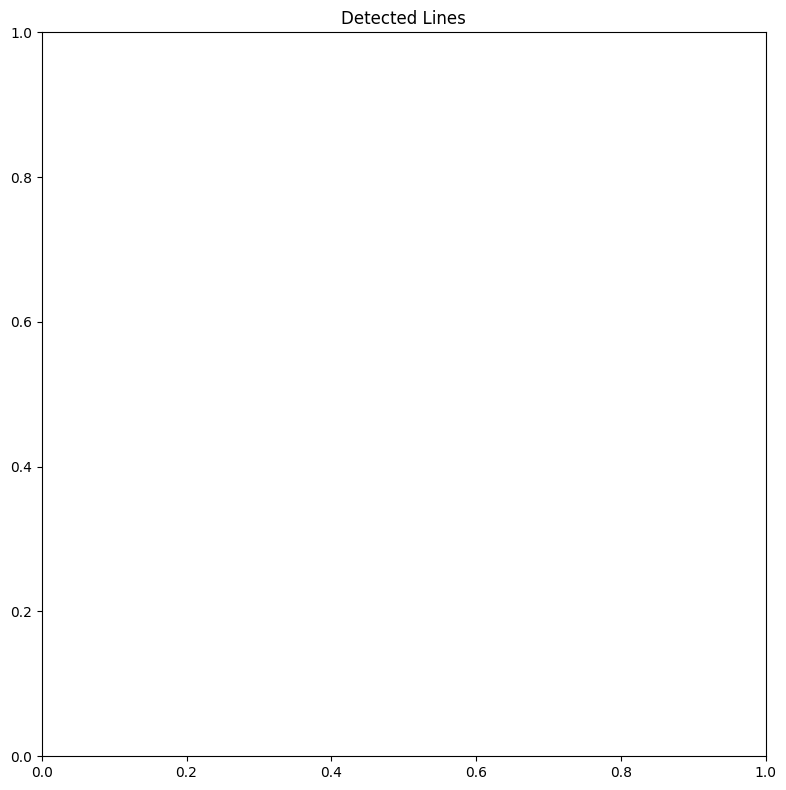

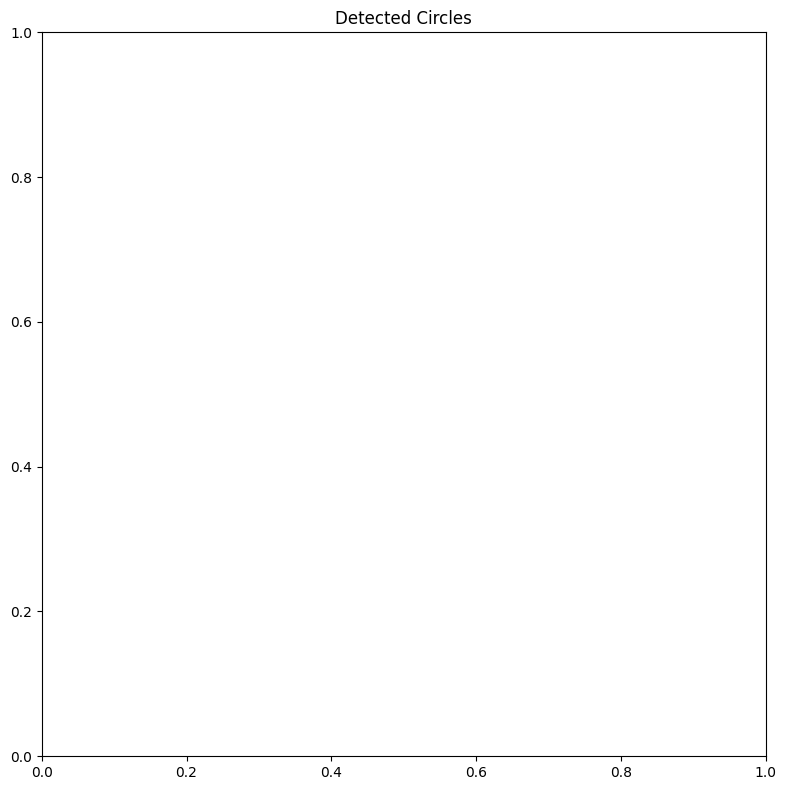

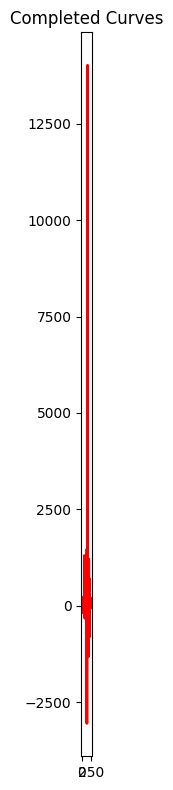

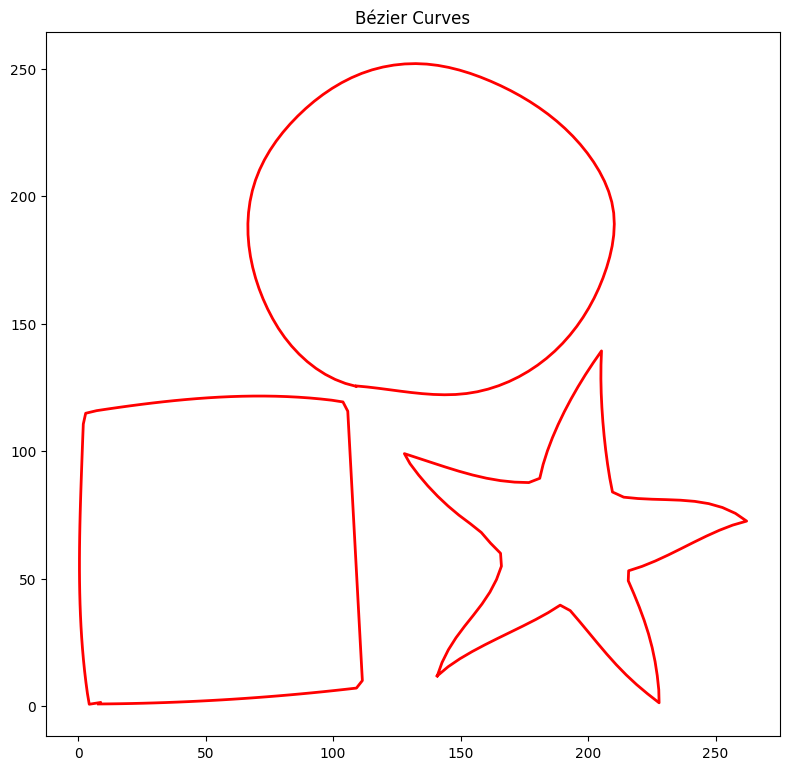

In [ ]:
# Define the path to the CSV file
csv_file_path = os.path.join('curvetopia_data', 'problems', 'isolated.csv')

# Read and visualize the isolated curve
path_XYs = read_csv(csv_file_path)
plot(path_XYs, "Original Polylines")

# Detect lines and circles
lines = detect_straight_lines(path_XYs)
circles = detect_circles(path_XYs)

# Plot detected lines and circles
plot([lines], "Detected Lines")
plot([circles], "Detected Circles")

# Complete curves if needed
completed_curves = [complete_curve(XY) for XYs in path_XYs for XY in XYs]
plot([completed_curves], "Completed Curves")

# Fit Bézier curves
bezier_curves = [fit_bezier(XY) for XYs in path_XYs for XY in XYs]
plot([bezier_curves], "Bézier Curves")
